In [4]:
import requests, json
#from bs4 import BeautifulSoup   
import numpy as np 
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from pandas.api.types import CategoricalDtype
#from sklearn.metrics import mean_absolute_percentage_error
#from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
from sklearn import datasets, linear_model
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import Pool, CatBoostRegressor
from tqdm import tqdm
from sklearn.base import clone

In [5]:
RANDOM_SEED = 42

In [219]:
sample_submission=pd.read_csv('submission00.csv')

In [6]:
test_cars=pd.read_csv('test_cars.csv')
test_cars=test_cars.drop(['car_url', 'complectation_dict', 'sell_id','image', 'model_info',
                          'parsing_unixtime', 'priceCurrency', 'super_gen', 'vendor', 'Unnamed: 32', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35', 'Unnamed: 36', 'Unnamed: 37', 'Unnamed: 38'], axis=1)
data_par = pd.read_csv('all_auto_ru_07_12_2020-11.csv')

data_par=data_par.drop([ 'start_date', 'hidden'], axis=1)
test_cars['sample']=1
data_par['sample']=0
data = test_cars.append(data_par, sort=False).reset_index(drop=True)
data.columns =  ['bodyType', 'brand', 'color', 'description', 'engineDisplacement',
       'enginePower', 'equipment_dict', 'fuelType', 'mileage', 'modelDate',
       'model_name', 'name', 'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'owners', 'Possession', 'PTS', 'drive_unit', 'rudder',
       'state', 'choky', 'sample', 'equipment_dict2', 'price']
data.head(3)

/Users/do/git/Skill_Factory/Project_5_Auto_Prices/venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (11,12,16,17,19,20,32,34,35,36,37,38) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,bodyType,brand,color,description,engineDisplacement,enginePower,equipment_dict,fuelType,mileage,modelDate,...,owners,Possession,PTS,drive_unit,rudder,state,choky,sample,equipment_dict2,price
0,лифтбек,SKODA,синий,"Все автомобили, представленные в продаже, прох...",1.2 LTR,105 N12,"{""engine-proof"":true,""tinted-glass"":true,""airb...",бензин,74000,2013,...,3 или более,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
1,лифтбек,SKODA,чёрный,ЛОТ: 01217195\nАвтопрага Север\nДанный автомоб...,1.6 LTR,110 N12,"{""cruise-control"":true,""asr"":true,""esp"":true,""...",бензин,60563,2017,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN
2,лифтбек,SKODA,серый,"Все автомобили, представленные в продаже, прох...",1.8 LTR,152 N12,"{""cruise-control"":true,""tinted-glass"":true,""es...",бензин,88000,2013,...,1 владелец,NaN,Оригинал,передний,Левый,Не требует ремонта,Растаможен,1,NaN,NaN


# Тут мы парсим сайт

# Проверим датасет на наличие пропусков:

In [7]:
data.isnull().sum()

bodyType                     0
brand                        0
color                        0
description               7212
engineDisplacement          10
enginePower                 10
equipment_dict            9992
fuelType                     3
mileage                      0
modelDate                    0
model_name                   0
name                        11
numberOfDoors                0
productionDate               0
vehicleConfiguration        10
vehicleTransmission         10
owners                      30
Possession              155240
PTS                         35
drive_unit                  10
rudder                       0
state                   192333
choky                        0
sample                       0
equipment_dict2          34686
price                    34690
dtype: int64

Заполним наны наиболее распостраненным значением или введём значение 'unknown' для случаев где очень много данных отсутствуют

In [8]:
nul_col=['engineDisplacement', 'enginePower', 'fuelType', 'name', 'vehicleConfiguration', 'vehicleTransmission', 'drive_unit', 'PTS', "owners" ]
for col in data[nul_col]:
    ch=data[col].value_counts().index[0]
    data[col]=data[col].fillna(ch)
unkn_col=['description', 'Possession', 'state']
for col in data[unkn_col]:
    data[col]=data[col].fillna('unknown')
    

In [9]:
data.isnull().sum()

bodyType                    0
brand                       0
color                       0
description                 0
engineDisplacement          0
enginePower                 0
equipment_dict           9992
fuelType                    0
mileage                     0
modelDate                   0
model_name                  0
name                        0
numberOfDoors               0
productionDate              0
vehicleConfiguration        0
vehicleTransmission         0
owners                      0
Possession                  0
PTS                         0
drive_unit                  0
rudder                      0
state                       0
choky                       0
sample                      0
equipment_dict2         34686
price                   34690
dtype: int64

В некоторых столбцах часто попадаются некорректно внесённые значения. Они, как правило не повторяются, поэтому можем отфильтровать их

In [10]:
'''
columns_to_clean=['bodyType', 'brand',  'engineDisplacement',
       'enginePower',  'fuelType', 'modelDate',
       'model_name',  'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'owners', 'Possession',
       'PTS', 'drive_unit', 'rudder',  'choky' ]
for col in columns_to_clean:
    
    #data_sub=data[data['sample']==1]
    data = data[data[col].isin(data[col].value_counts()[data[col].value_counts()>5].index)]

data.head(3)
'''

"\ncolumns_to_clean=['bodyType', 'brand',  'engineDisplacement',\n       'enginePower',  'fuelType', 'modelDate',\n       'model_name',  'numberOfDoors', 'productionDate',\n       'vehicleConfiguration', 'vehicleTransmission', 'owners', 'Possession',\n       'PTS', 'drive_unit', 'rudder',  'choky' ]\nfor col in columns_to_clean:\n    \n    #data_sub=data[data['sample']==1]\n    data = data[data[col].isin(data[col].value_counts()[data[col].value_counts()>5].index)]\n\ndata.head(3)\n"

In [11]:
'''
columns_to_clean_sample=['bodyType', 'brand',  'engineDisplacement',
       'enginePower',  'fuelType', 'modelDate',
       'model_name',  'numberOfDoors', 'productionDate',
       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС',
       'Привод', 'Руль', 'Состояние', 'Таможня' ]
'''       

"\ncolumns_to_clean_sample=['bodyType', 'brand',  'engineDisplacement',\n       'enginePower',  'fuelType', 'modelDate',\n       'model_name',  'numberOfDoors', 'productionDate',\n       'vehicleConfiguration', 'vehicleTransmission', 'Владельцы', 'Владение', 'ПТС',\n       'Привод', 'Руль', 'Состояние', 'Таможня' ]\n"

In [12]:
'''
for col in columns_to_clean_sample:
    sample_submission = sample_submission[sample_submission[col].isin(sample_submission[col].value_counts()[sample_submission[col].value_counts()>5].index)]
sample_submission.shape  
'''

'\nfor col in columns_to_clean_sample:\n    sample_submission = sample_submission[sample_submission[col].isin(sample_submission[col].value_counts()[sample_submission[col].value_counts()>5].index)]\nsample_submission.shape  \n'

# Обработаем числовые признаки

Столбцы "enginePower" , 'name', 'engineDisplacement', 'owners' помимо нужных нам числовых знвчений содержат ненужные текстовые. Начнём с чистки этих столбцов.

In [13]:
def splitting(s):
    return str(s).split(" ")[0]
data["enginePower"]=data["enginePower"].map(lambda s: splitting(s))
data['name']=data['name'].map(lambda s: splitting(s))
data['engineDisplacement'] = data['engineDisplacement'].map(lambda s: splitting(s))
data['owners'] = data['owners'].map(lambda s: splitting(s))
#data['owners'].apply(splitting)

Некоторые признаки хоть и выглядят как числовые имеют тип стринг. Выполним преобразование. 

In [14]:
def convert_to_int(col):
    def reg_clien(stringa):
        stringa=str(stringa).strip()
        try:
            res=re.findall('\d+\.?\d+', string=str(stringa))[0]
        except: 
            res = '0'
        return res
    
    data[col] = data[col].fillna('0')
    data[col] = data[col].map(lambda a: reg_clien(a))
    data[col] = data[col].astype(np.float64)
    #data[col].astype(np.int32, inplace=True)
        


for col in ['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners' ]:
    convert_to_int(col)




In [15]:
def doors(row):
    try:
        return int(row['numberOfDoors'].strip())
    except:
        return 5
data['numberOfDoors']=data.apply(lambda row:  doors(row), axis=1 )

Убедимся, что преобразование сработало:

In [16]:
for col in ['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors' ]:
    print(data[col].dtypes)

float64
float64
float64
float64
float64
float64
float64
int64


/Users/do/git/Skill_Factory/Project_5_Auto_Prices/venv/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


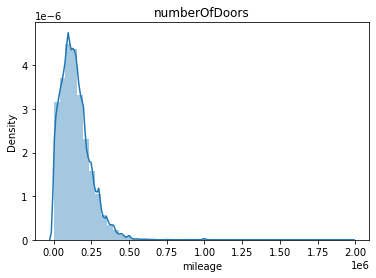

In [17]:
plt.figure()
sns.distplot(data['mileage'])
plt.title(col)
plt.show()
    

In [18]:
data['numberOfDoors'].value_counts()

5    211889
4     13339
2      1172
3       618
0         1
Name: numberOfDoors, dtype: int64

In [19]:
X_num = data[['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors']][data['sample']==0]
X_num_sub = data[['mileage', "productionDate", "enginePower", 'name', 'engineDisplacement', 'modelDate', 'owners', 'numberOfDoors']][data['sample']==1]

# Бинарные признаки

Столбцы 'drive_unit','rudder','state', 'choky' относятся к бинарным.
Над столбцом 'PTS' нужно произвести некоторые преобразования:
    

In [20]:
data['PTS'].value_counts()

ORIGINAL              168138
Оригинал               30093
DUPLICATE              24200
Дубликат                4585
3 года и 6 месяцев         1
9 лет и 10 месяцев         1
1085512260                 1
Name: PTS, dtype: int64

In [21]:
data['PTS'] = data['PTS'].str.replace('Оригинал', 'ORIGINAL')
data['PTS'] = data['PTS'].str.replace('Дубликат', 'DUPLICATE')
data['PTS'].value_counts()

ORIGINAL              198231
DUPLICATE              28785
3 года и 6 месяцев         1
9 лет и 10 месяцев         1
1085512260                 1
Name: PTS, dtype: int64

In [22]:
data['rudder'] = data['rudder'].str.replace('Левый', 'LEFT')
data['rudder'] = data['rudder'].str.replace('Правый', 'RIGHT')

In [23]:
data['choky']=data['choky'].astype('str')

In [24]:
X_bin = data[['drive_unit','rudder','state',  'PTS','choky']]
#bin_cols = ['drive_unit','rudder','state',  'PTS','choky']


In [25]:
label_encoder = LabelEncoder()

for column in X_bin.columns:
    X_bin[column] = label_encoder.fit_transform(X_bin[column])
X_bin.head(3)

<ipython-input-25-6e75c4ece4d0>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_bin[column] = label_encoder.fit_transform(X_bin[column])


,drive_unit,rudder,state,PTS,choky
0,4,1,2,4,3
1,4,1,2,4,3
2,4,1,2,4,3


# Категориальные и бинарные признаки

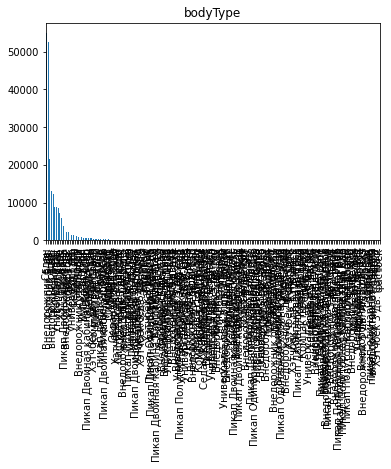

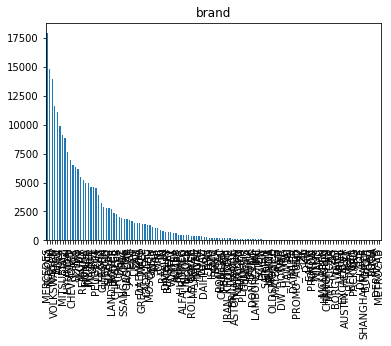

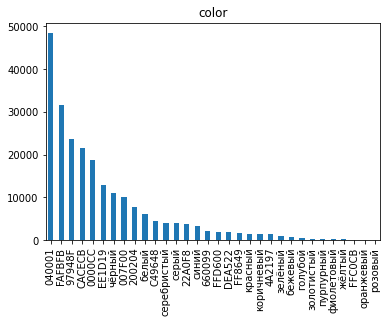

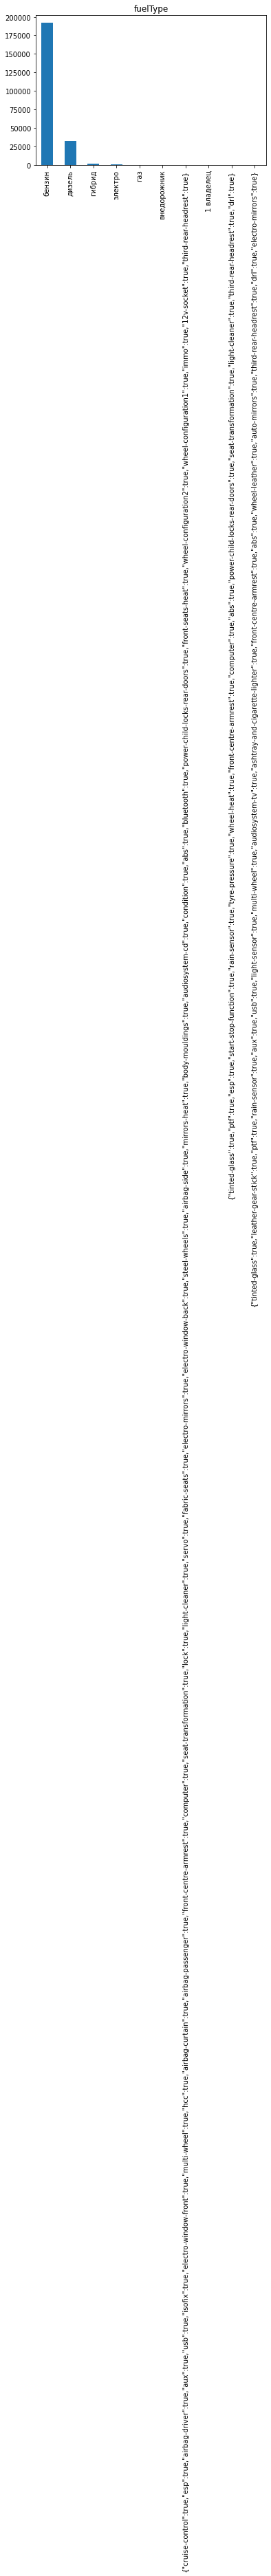

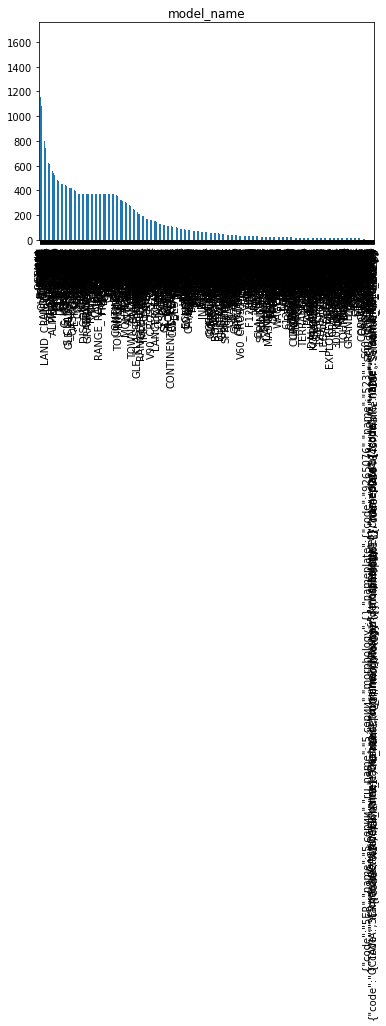

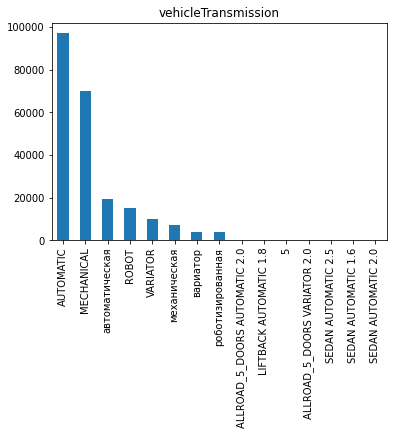

In [26]:
for col in ['bodyType', 'brand', 'color',   'fuelType', 
       'model_name',   'vehicleTransmission']:
    col_to_show=data[col].value_counts()
    col_to_show.plot(kind='bar', title=col)
    #sns.countplot(x=data[column], data=data[bin_cols])
    plt.show()

In [27]:
for col in ['bodyType', 'brand', 'color',   'fuelType', 
       'model_name',   'vehicleTransmission']:
    print('________________________')
    print(col)
    print('________________________')
    print(data[col].value_counts())

________________________
bodyType
________________________
Седан                      54920
Внедорожник 5 дв.          52689
Хэтчбек 5 дв.              21507
седан                      13147
внедорожник 5 дв.          12228
                           ...  
пикап полуторная кабина        5
внедорожник открытый           3
тарга                          2
Хэтчбек 3 дв. Compact          2
фастбек                        1
Name: bodyType, Length: 199, dtype: int64
________________________
brand
________________________
MERCEDES      17881
TOYOTA        14820
NISSAN        13980
VOLKSWAGEN    11585
BMW           11103
              ...  
GAC              10
PUCH             10
TATRA            10
DERWAYS          10
METROCAB         10
Name: brand, Length: 130, dtype: int64
________________________
color
________________________
040001         48423
FAFBFB         31664
97948F         23729
CACECB         21559
0000CC         18763
EE1D19         12863
чёрный         11010
007F00         101

Признаки, имеющие не очень большое количество разных значений кодируем OneHotEncoder

In [28]:
X_cat_1=[['fuelType', 'vehicleTransmission']]

In [29]:
X_cat_1= OneHotEncoder(sparse = False).fit_transform(data[['fuelType', 'vehicleTransmission']])
X_cat_1

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Значения остальных категориальных признаков заменим количеством их повторений в датасете.

In [30]:
X_cat_2 = data[['brand','bodyType','color','model_name']]
vc_brands = data['brand'].value_counts()
vc_body = data['bodyType'].value_counts()
vc_color = data['color'].value_counts()
vc_model =  data['model_name'].value_counts()

def encoder_br(row):
    br=row['brand']
    return vc_brands[br]

def encoder_body(row):
    bo=row['bodyType']
    return vc_body[bo]

def encoder_color(row):
    co=row['color']
    return vc_color[co]

def encoder_model(row):
    mo=row['model_name']
    return vc_model[mo]


    
X_cat_2['brand']=data.apply(lambda row: encoder_br(row), axis=1)
X_cat_2['bodyType']=data.apply(lambda row: encoder_body(row), axis=1)
X_cat_2['color']=data.apply(lambda row: encoder_color(row), axis=1)
X_cat_2['model_name']=data.apply(lambda row: encoder_model(row), axis=1)





<ipython-input-30-9d0792174984>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat_2['brand']=data.apply(lambda row: encoder_br(row), axis=1)
<ipython-input-30-9d0792174984>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat_2['bodyType']=data.apply(lambda row: encoder_body(row), axis=1)
<ipython-input-30-9d0792174984>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [31]:
X_cat_2

,brand,bodyType,color,model_name
0,5471,2232,3289,1676
1,5471,2232,11010,1676
2,5471,2232,3984,618
3,5471,2232,1501,1676
4,5471,2232,6133,1676
...,...,...,...,...
227014,2338,54920,31664,10
227015,2338,54920,31664,10
227016,2338,54920,31664,10
227017,2338,54920,31664,10


# Превратим длинные строковые значения в столбце 'equipment_dict' в списки.

In [32]:
def dict_1(row):
    try:
        res= list(json.loads(row['equipment_dict']).keys())
    except:
        res=[]
    
    return res
data['equipment_dict']=data.apply(lambda row: dict_1(row), axis=1)

In [33]:
data['equipment_dict']

0         [engine-proof, tinted-glass, airbag-driver, au...
1         [cruise-control, asr, esp, airbag-driver, isof...
2         [cruise-control, tinted-glass, esp, adaptive-l...
3         [cruise-control, roller-blind-for-rear-window,...
4         [cruise-control, asr, esp, airbag-driver, isof...
                                ...                        
227014                                                   []
227015                                                   []
227016                                                   []
227017                                                   []
227018                                                   []
Name: equipment_dict, Length: 227019, dtype: object

Из столбца 'equipment_dict2' выгрузим значения 'available_options' в json

In [34]:
def dict_2(row):
    try:
        res= json.loads(row['equipment_dict2'].replace("'", '"'))['available_options']
    except:
        res=[]
    
    return res
data['equipment_dict2']=data.apply(lambda row: dict_2(row), axis=1)

Теперь в столбцах 'equipment_dict' и 'equipment_dict2'расположениы списки укомплектации для каждой машины. Посмотрим какие элементы комплектации встречаются чаще всего, чтоб создать отдельные признаки опираясь на наличие этих элементов

In [35]:
equip=[]
for car in data['equipment_dict']:
    try:
        for eq in car:
            equip.append(eq)
 
    except:
        continue
equipment=pd.Series(equip)
equipment=equipment.value_counts()
equipment=equipment[equipment.values>10000]
equipment

lock                    21145
abs                     20760
electro-mirrors         18788
airbag-driver           17650
computer                17480
electro-window-front    17429
front-seats-heat        17320
airbag-passenger        17196
ptf                     16159
immo                    15935
electro-window-back     15247
airbag-side             14668
aux                     14443
wheel-power             14342
esp                     14146
mirrors-heat            13940
wheel-leather           13579
multi-wheel             13025
usb                     12943
front-centre-armrest    12842
wheel-configuration1    12563
rain-sensor             12546
light-sensor            12353
bluetooth               11896
cruise-control          11866
light-cleaner           11762
12v-socket              11750
tinted-glass            11658
leather                 10796
alloy-wheel-disks       10440
wheel-configuration2    10198
park-assist-r           10195
isofix                  10075
seat-trans

In [36]:
X_cat_3=pd.DataFrame(data['sample'])
for col in equipment.index:
    def eq_col(row):
        return int((col in row['equipment_dict']) or (col in row['equipment_dict2']) )
    
    X_cat_3[col]=data.apply(lambda row: eq_col(row), axis=1)
X_cat_3_sub=pd.DataFrame(X_cat_3)
X_cat_3 = X_cat_3[X_cat_3['sample']==0]
X_cat_3_sub = X_cat_3_sub[X_cat_3_sub['sample']==1]

Стандартизируем числовые признаки:

In [37]:

X_num=StandardScaler().fit_transform(X_num)
X_cat_3=StandardScaler().fit_transform(X_cat_3)
X_cat_3_sub=StandardScaler().fit_transform(X_cat_3_sub)


In [38]:
# Объединяем

X = np.hstack([X_num, X_bin[data['sample']==0], X_cat_1[data['sample']==0], X_cat_2[data['sample']==0], X_cat_3])

X_sub= np.hstack([X_num_sub, X_bin[data['sample']==1], X_cat_1[data['sample']==1], X_cat_2[data['sample']==1], X_cat_3_sub])


In [39]:

y = data['price'][data['sample']==0]
y

34686     199000.0
34687     199000.0
34688     199000.0
34689     199000.0
34690     199000.0
            ...   
227014     45000.0
227015     45000.0
227016     45000.0
227017     45000.0
227018     45000.0
Name: price, Length: 192333, dtype: float64

Поделим выборку на тренировочную и тестовую

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

# Функция для определения MAPE

In [41]:
#from sklearn.utils import check_arrays
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = check_arrays(y_true, y_pred)

    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    print('MAPE:', np.mean(np.abs((y_true - y_pred) / y_true)) * 100)

# Подберём модели:¶

Пробуя применять различные модели машинного обучения, я с толкнулась с тем, что получившийся датасет оказался черезчур большим и пришлось использовать его срез.

In [128]:
X_train2.shape

(3077, 77)

In [83]:
y_train2.shape

(15386,)

In [84]:
X_test2.shape

# X_train2 = pd.DataFrame(X_train)
# X_train2 = X_train2.loc[0:8999, :]
# X_test2 = pd.DataFrame(X_test)
# X_test2 = X_test2.loc[0:8999, :]

# y_train2=y_train
# y_train2=y_train2.iloc[0:9000]

(3846, 77)

Линейнай регрессия не работает, выдавая ошибку "LinAlgError: SVD did not converge in Linear Least Squares"

In [85]:
LR=  linear_model.LinearRegression()
LR.fit(X_train2, y_train2)
y_pred_LR=LR.predict(X_test)
print('MAPE:', np.mean(np.abs((y_test - y_pred_LR) / y_test)) * 100)

MAPE: 197.19835542617895


In [86]:
from sklearn.ensemble import RandomForestRegressor
from pprint import pprint
rf_1= RandomForestRegressor(random_state = RANDOM_SEED)
#from pprint import pprint
# Look at parameters used by our current forest
print('Параметры по умолчанию:\n')
pprint(rf_1.get_params())

Параметры по умолчанию:

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}


In [87]:
rf_1.fit(X_train2, y_train2)
y_pred_rf_1=rf_1.predict(X_test)
print('MAPE:', np.mean(np.abs((y_test - y_pred_rf_1) / y_test)) * 100)

MAPE: 19.920058208414265


Подберём параметры

In [88]:
"""
from sklearn.model_selection import GridSearchCV
param_grid = { 
    'n_estimators': [100, 200, 500, 1000],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    
}

#model = RandomForestRegressor()
#model.fit(X_train2, y_train2)

gridCV = GridSearchCV(estimator=rf_1, param_grid=param_grid, cv= 5)
rf_2=gridCV.fit(X_train2, y_train2)

print(gridCV.best_params_)
"""

"\nfrom sklearn.model_selection import GridSearchCV\nparam_grid = { \n    'n_estimators': [100, 200, 500, 1000],\n    'max_features': ['auto', 'sqrt', 'log2'],\n    'max_depth' : [4,5,6,7,8],\n    \n}\n\n#model = RandomForestRegressor()\n#model.fit(X_train2, y_train2)\n\ngridCV = GridSearchCV(estimator=rf_1, param_grid=param_grid, cv= 5)\nrf_2=gridCV.fit(X_train2, y_train2)\n\nprint(gridCV.best_params_)\n"

In [89]:
"""
rf_2.fit(X_train2, y_train2)
y_pred_rf_2=rf_2.predict(X_test)
print('MAPE:', np.mean(np.abs((y_test - y_pred_rf_2) / y_test)) * 100)
"""

"\nrf_2.fit(X_train2, y_train2)\ny_pred_rf_2=rf_2.predict(X_test)\nprint('MAPE:', np.mean(np.abs((y_test - y_pred_rf_2) / y_test)) * 100)\n"

In [90]:
"""
y_pred_rf_2=rf_2.predict(X_test)
print('MAPE:', np.mean(np.abs((y_test - y_pred_rf_2) / y_test)) * 100)
"""

"\ny_pred_rf_2=rf_2.predict(X_test)\nprint('MAPE:', np.mean(np.abs((y_test - y_pred_rf_2) / y_test)) * 100)\n"

In [91]:
tree = DecisionTreeRegressor(max_features=int(X_train2.shape[1]/3), max_depth=50)
tree.fit(X_train2, y_train2)
y_pred_tree = tree.predict(X_test)
print('MAPE:', np.mean(np.abs((y_test - y_pred_tree ) / y_test)) * 100)

MAPE: 19.888564548394918


In [92]:
gb = GradientBoostingRegressor(max_depth=7,n_estimators=1000,learning_rate=0.1,random_state=RANDOM_SEED)
gb.fit(X_train2, y_train2)
y_pred_gb = gb.predict(X_test)
print('MAPE:', np.mean(np.abs((y_test - y_pred_gb) / y_test)) * 100)


MAPE: 17.708543578805124


# Применим Stacking

In [140]:
def compute_meta_feature(model, X_train, X_test, y_train, cv):
    
    #!!!!!!!!n_classes = len(np.unique(y_train))
    X_meta_train = np.zeros(len(y_train), dtype=np.float32)
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    splits = cv.split(X_train)
    for train_fold_index, predict_fold_index in splits:
       # print("X_train.shape:", X_train.shape)
       # print("len(train_fold_index):",len(train_fold_index))
       # print("len(predict_fold_index):",len(predict_fold_index))
       # print("X_train.shape:", X_train.shape)
        #print('X_train[train_fold_index]', X_train[train_fold_index])
        #print('X_train[predict_fold_index]', X_train[predict_fold_index])
        
       # print("X_train:",X_train)
       # print("train_fold_index:",train_fold_index)
       # print("predict_fold_index:",predict_fold_index)
        
#X_fold_train = X_train[train_fold_index] #здесь происходит ошибка
        X_fold_train = X_train[train_fold_index]
        X_fold_predict = X_train[predict_fold_index]
        y_fold_train = y_train[train_fold_index]
        
        folded_model = clone(model)
        folded_model.fit(X_fold_train, y_fold_train)

        X_meta_train[predict_fold_index] = folded_model.predict(X_fold_predict)
        # print('X_meta_train', X_meta_train)
    
    meta_model = clone(model)
    meta_model.fit(X_train, y_train)
    
    X_meta_test = meta_model.predict(X_test)
    
    return X_meta_train, X_meta_test

In [141]:
def generate_meta_features(models, X_train, X_test, y_train, cv):
   
    features = [
        compute_meta_feature(model, X_train, X_test, y_train, cv)
        for model in tqdm(models)
    ]

    stacked_features_train = np.column_stack([
        features_train for features_train, features_test in features
    ])

    stacked_features_test = np.column_stack([
        features_test for features_train, features_test in features
    ])
    
    return stacked_features_train, stacked_features_test

In [223]:
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)

# scaler = StandardScaler()
# scaler.fit_transform()
splits = cv.split(X_train)
for bigger, smaller in splits:
    X_train2 = X_train[smaller]
    y_train2 = np.array(y_train)[smaller]

splits = cv.split(X_test)
for bigger, smaller in splits:
    X_test2 = X_test[smaller]
    y_test2 = np.array(y_test)[smaller]


In [226]:
cv = KFold(n_splits=10, shuffle=True, random_state=RANDOM_SEED)


In [227]:
stacked_features_train, stacked_features_test = generate_meta_features([
    RandomForestRegressor(n_estimators=300, n_jobs=-1),
    DecisionTreeRegressor(),
    GradientBoostingRegressor(n_estimators=200)
], X_train2, X_test2, y_train2, cv)

100%|██████████| 3/3 [02:37<00:00, 52.39s/it]


In [240]:
st_stacked_features_train = StandardScaler().fit_transform(stacked_features_train)
# pd.DataFrame(st_stacked_features_train).plot()

In [241]:
meta_GR = GradientBoostingRegressor()
meta_GR.fit(st_stacked_features_train, y_train2)
y_pred_LR = meta_GR.predict(stacked_features_test)
# print('MAPE:', np.mean(np.abs((y_test - y_pred_LR) / y_test)) * 100)

Catboost

In [243]:
cbr = CatBoostRegressor()

In [244]:
X_test

array([[ 1.62878259, -0.85482553, -0.8734183 , ..., -0.17859404,
        -0.22953311, -0.28095262],
       [ 0.06813653,  0.24485047, -0.81779642, ..., -0.17859404,
        -0.22953311, -0.28095262],
       [-1.22713888,  1.14458537, -0.243037  , ..., -0.17859404,
        -0.22953311, -0.28095262],
       ...,
       [ 0.42282882,  0.64473265, -0.42844326, ..., -0.17859404,
        -0.22953311, -0.28095262],
       [-1.18342053,  1.14458537,  0.67472402, ..., -0.17859404,
        -0.22953311, -0.28095262],
       [-0.77096407, -0.95479607,  0.99918499, ..., -0.17859404,
        -0.22953311, -0.28095262]])

In [252]:
X_sub

array([[ 7.40000000e+04,  2.01400000e+03,  1.05000000e+02, ...,
         1.54992129e+00,  1.56293927e+00,  1.56512845e+00],
       [ 6.05630000e+04,  2.01700000e+03,  1.10000000e+02, ...,
         1.54992129e+00,  1.56293927e+00, -6.38925197e-01],
       [ 8.80000000e+04,  2.01400000e+03,  1.52000000e+02, ...,
         1.54992129e+00,  1.56293927e+00,  1.56512845e+00],
       ...,
       [ 3.60000000e+05,  1.99700000e+03,  1.70000000e+02, ...,
        -6.45194053e-01, -6.39820126e-01, -6.38925197e-01],
       [ 9.05000000e+04,  2.01300000e+03,  1.84000000e+02, ...,
         1.54992129e+00,  1.56293927e+00,  1.56512845e+00],
       [ 2.40000000e+05,  2.00800000e+03,  2.35000000e+02, ...,
        -6.45194053e-01, -6.39820126e-01, -6.38925197e-01]])

# Submission


In [253]:
predict_submission = meta_GR.predict(X_sub)
predict_submission

ValueError: Number of features of the model must match the input. Model n_features is 3 and input n_features is 77 

In [247]:
#predict_submission.value_counts()

In [248]:
predict_submission

array([2.20443309e+08, 2.20532836e+08, 2.20746978e+08, ...,
       2.21660678e+08, 2.20989618e+08, 2.21574652e+08])

In [249]:
sample_submission.shape

(34686, 2)

In [250]:
sample_submission['price'] = predict_submission
sample_submission.to_csv(f'submission.csv', index=False)
sample_submission.head(10)

,sell_id,price
0,1100575026,2.204433e+08
1,1100549428,2.205328e+08
2,1100658222,2.207470e+08
3,1100937408,2.205045e+08
4,1101037972,2.204691e+08
5,1100912634,2.208876e+08
6,1101228730,2.210341e+08
7,1100165896,2.204691e+08
8,1100768262,2.206553e+08
9,1101218501,2.211714e+08


In [251]:
X_train.shape

(153866, 77)